## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 21: Reinforcement Learning - Notebook 2: Q-Learning

Some code here is adapted from
https://www.nervanasys.com/demystifying-deep-reinforcement-learning/

This is for learning with Q-Learning and Sarsa

There are two games: three_in_a_row_score and two_by_two_box_score (no reason not to add more)

Each returns 1 if the condition is exactly met, else 0
(so we're doing positive reinforcement only, no punishment. To punish return -1 if not a win)

 We have the ability to decay the exploration by reducing the chance of picking a random
 action, rather than the best. I've found that with these tasks, going random about as
   much as possible is best, since we get to search the space broadly in a relatively small
   number of runs.

 This file is basically a bunch of tools for learning Flippers and building the
 images. For each game illustration, set the learning strategy (Q or Sarsa), the
 action-selection policy, the global variables, the number of episodes, the game
 number, etc. Then train the model (if needed) and then run the game, saving the
 results in a PostScript file. Each game needs the file to be manually configured
 in this way and then re-run. 

 Unlike most of the other figure-making notebooks, this one needs to be modified
 by hand to produce each of the figures that we want. I'm sure with some effort it
 can be cleaned up and all the steps parameterized, but this code is reasonably
 clean, and it works properly, so I'm going to leave it as-is.

 There are lots of globals in this code, so it's important to run
 the cells sequentially. 

 The first block of variables control the building of the Q table, including Q or Sarsa
 The second block of variables control the layout of the PostScript files showing the game

#### TO MAKE ILLUSTRATIONS:

 Because Python's native graphics are so lousy, pictures are saved as PostScript files.

-   Set the algorithm and #runs and the game type
-    If your configuration doesn't exist, it will learn and save to file. 
- Else it will read the file.
    
To find good examples:

-    Print out the number of states used for every starting board#    Try different #runs (1k, 5k, 10k, 50k, etc.) and note different #states
-    Find games that are long with small #runs, and shorter later, showing learning
-    For 3 in a row, game 343 is nice, with 7 steps at 1k runs, but only 3 at 10k


In [1099]:
import numpy as np
from numpy import random
import math
import pickle
import matplotlib.pyplot as plt
import os

In [1100]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [1101]:
# This is the heart of the learning algorithm. We play a game and update the Q table.
def run_one_episode_of_learning(episode_number):
    global board, state_visited, Q
    reset_all()
    state0 = get_board_state()
    score0 = get_board_score()
    step_count = 0
    if learning_algorithm == 'Sarsa':
        action0 = epsilon_greedy_policy(episode_number, state0)

    while step_count < max_steps:
        if score0 == 1:
            for action_number in range(num_actions):
                win_value = 1 / math.sqrt(max(1, step_count))
                Q[state0][action_number] = win_value  # give a winning score (nice when printing game charts)
            return  # the episode is over when we have a winning board

        if learning_algorithm == 'Q':
            action0 = epsilon_greedy_policy(episode_number, state0)

        # Take the action
        (x, y) = action_to_xy(action0)
        make_game_move(x, y)

        # rarely, random stuff happens in the world and the board changes on us
        add_surprise()

        # Find the new state and new score
        state1 = get_board_state()
        score1 = get_board_score()

        # Get the reward. It's 1 if we've won, else -1
        reward = non_winning_reward
        if score1 == 1:
            reward = 1

        # get next action
        if learning_algorithm == 'Q':
            action1 = np.argmax(Q[state1])
        else:
            action1 = epsilon_greedy_policy(episode_number, state1)

        # Bellman's equation to update the Q score
        Q[state0][action0] += learning_rate * (reward + (gamma * Q[state1][action1]) - Q[state0][action0])

        # The new state becomes the starting state for the next time through
        state0 = state1
        score0 = score1
        action0 = action1

        step_count += 1

        # A little optimization: if we've seen this state before, we're in a loop so quit.
        # if state_visited[state0]:
        #     return
        state_visited[state0] = True

In [1102]:
def epsilon_greedy_policy(episode_number, state):
    # Choose an action. If under epsilon (which decays), pick randomly, else pick best Q-score
    threshold = 0
    drop_limit = epsilon_stop_percent * num_episodes
    if episode_number < drop_limit:
        threshold = epsilon_max * np.exp(-5 * episode_number / drop_limit) # starts at e_max, drops to .006 (call it 0)
    if random.rand() < threshold:
        action = random.randint(0, num_actions)
    else:
        action = np.argmax(Q[state])
    return action

In [1103]:
# prepare for a new episode
def reset_all():
    global board, state_visited
    board_state = random.randint(0, num_states)
    board_from_state(board_state)
    state = get_board_state()
    state_visited = [False for i in range(num_states)]
    state_visited[state] = True

In [1104]:
##########
# Utilities for manipuating the board, working with actions, etc.
# These are from Q-table-builder, and probably should be in a common
# file that both modules import, but for now repeating them is file
##########

# return the x and y coordinates for an action number
def action_to_xy(action):
    y = int(action * 1. / board_size)
    x = int(action - (y * board_size))
    return (x, y)


# cells are worth 1, 2, 4, 8, 16... in reading order from UL
def get_board_state():
    flat_board = np.ravel(board)
    score = sum([flat_board[i] * (2 ** i) for i in range(flat_board.size)])
    return int(score)


# given a state number, recreate the board
def board_from_state(state):
    global board
    binary_state = state_in_binary(state)
    flat_board = [int(binary_state[i]) for i in range(len(binary_state))]
    # print("   board from state: flat_board = {}".format(flat_board))
    board = np.reshape(flat_board, [board_size, board_size])


# return a binary string describing the board contents, starting in UL, row 1 L->R, row 2 L->R, etc.
def state_in_binary(state):
    format_string = "{0:0" + str(num_actions) + "b}"
    binary_version = ''.join(reversed(format_string.format(state)))
    return binary_version

In [1105]:
def add_surprise():
    global board, num_actions, random_event_probability
    if random.rand() < random_event_probability:
        action = random.randint(0, num_actions)
        (x, y) = action_to_xy(action)
        make_game_move(x, y)

In [1106]:
# return 1 if we have exactly 1 row or column of 1's, else 0
def three_in_a_row_score():
    global board
    total_ones = np.sum(np.ravel(board))
    if total_ones != board_size:
        return 0  # early exit, too few or too many 1's
    column_totals = np.sum(board, 0)
    if max(column_totals) == board_size:
        return 1
    row_totals = np.sum(board, 1)
    if max(row_totals) == board_size:
        return 1
    return 0


def three_in_a_row_move(x, y):
    global board
    board[y][x] = 1 - board[y][x]


def three_in_a_row_name():
    return 'three-in-a-row'

In [1107]:
# return 1 if we have a 2-by-2 box. This could be faster, but this is simple
def two_by_two_box_score():
    global board
    total_ones = np.sum(np.ravel(board))
    if total_ones != 4:
        return 0  # early exit, too few or too many 1's
    for y in range(board_size - 1):
        for x in range(board_size - 1):
            if board[y][x] == 1:
                if (board[y + 1][x] == 1) and (board[y][x + 1] == 1) and (board[y + 1][x + 1] == 1):
                    return 1
    return 0


def two_by_two_box_move(x, y):
    global board
    board[y][x] = 1 - board[y][x]


def two_by_two_box_name():
    return 'two-by-two'

In [1108]:
# ridiculously slow. scan every 1 and see if it's a plus center
def plus_sign_score():
    global board
    total_ones = np.sum(np.ravel(board))
    if total_ones != 5:
        return 0  # early exit, too few or too many 1's
    for y in np.arange(1, board_size - 1):
        for x in np.arange(1, board_size - 1):
            if board[y][x] == 1:
                if (board[y - 1][x] == 1) and (board[y + 1][x] == 1) and (board[y][x - 1] == 1) and (
                    board[y][x + 1] == 1):
                    return 1
    return 0


def plus_sign_move(x, y):
    global board
    board[y][x] = 1 - board[y][x]
    if x > 0:
        board[y][x - 1] = 1 - board[y][x - 1]
    if x < board_size - 1:
        board[y][x + 1] = 1 - board[y][x + 1]
    if y > 0:
        board[y - 1][x] = 1 - board[y - 1][x]
    if y < board_size - 1:
        board[y + 1][x] = 1 - board[y + 1][x]


def plus_sign_name():
    return 'plus-sign'

In [1109]:
###############################
# Building the Q table
###############################
num_episodes  = 15000            # number of games to play to train Q table (10000)
board_size = 3                   # side length of square board (more than 4 is playing with fire) (3)
learning_rate = 0.99             # lerp value from old score to new (0.99)
gamma = 0.85                     # discount on future scores (0.85)
random_event_probability = 0.10  # how likely it is that a random tile will flip on us after a move (0.1)
epsilon_max = .8                 # how likely we are to pick a random action, decays with episodes
epsilon_stop_percent = .5        # how far into this series of runs until epsilon hits 0
num_random_games = 1000          # for the "average game length" printout after the table is built (1000)
random_seed = 3                  # seeding the RNG
non_winning_reward = 0           # set to -1 for "punishment", 0 for "positive reinforcement only"
max_steps = 99                   # max single episode length of moves

In [1110]:
###############################
# Choose the game to play
###############################
game_functions = ( (three_in_a_row_score, three_in_a_row_move, three_in_a_row_name),
                   (two_by_two_box_score, two_by_two_box_move, two_by_two_box_name),
                   (plus_sign_score, plus_sign_move, plus_sign_name) )
(get_board_score, make_game_move, game_name) = game_functions[0]  # choose the game to play

# choose these by hand to make nice examples for figures
game_list_3_cross = (163, 343, 313, 495)  # good for 3-by-3 cross
game_list_4_cross = (33444, 10344, 44122, 18705) # good for 4-by-4 cross
game_list = ( 49, 182 )

learning_algorithm = 'Q'        # either 'Q' or 'Sarsa'

In [1111]:
###############################
# Global variables built from the user-defined variables
###############################
num_actions = num_states = total_board_cells = Q = state_visited = board = None


def start_run():
    global Q
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    filename = data_dir + "/" + "Qtable-size-" + str(board_size) + "-alg-" + learning_algorithm + "-episodes-" + str(num_episodes) + "-game-" + game_name() + ".pkl"
    if os.path.exists(filename):
        read_data_file(filename)
    else:
        make_derived_variables()
        Q = np.zeros([num_states, num_actions], dtype='float')  # initialize Q table to all 0
        random.seed(random_seed)
        for episode_number in range(num_episodes):
            if episode_number % 1000 == 0:
                print("Starting episode {}".format(episode_number))
            run_one_episode_of_learning(episode_number)
        save_data_file(filename)

    print_all_game_lengths()   # this helps us choose good games to plot

    save_games(save_chart, game_list)
    save_games(save_sequence, game_list)

    plot_results()  # in PyCharm this hangs until the window is closed, so make it last step
    print_averages()

In [1112]:
def print_averages():
    total_moves = 0
    max_moves = 0
    for game_number in range(num_states):
        (action_list, state_list) = run_game(game_number)
        total_moves += action_list.size
        max_moves = max(max_moves, action_list.size)
    average_moves = total_moves * 1.0 / num_states
    flat_Q = np.ravel(Q)
    average_Q = np.average(flat_Q)
    min_Q = min(flat_Q)
    max_Q = max(flat_Q)
    print("learning_algorithm = {}\nnum_episodes = {}\naverage_moves = {}\nmin_Q = {}\naverage_Q = {}\nmax_Q = {}"
          .format(learning_algorithm, num_episodes, average_moves, min_Q, average_Q, max_Q))
    print("max_moves = {}".format(max_moves))


In [1113]:
def save_data_file(filename):
    master_dict = {}
    master_dict.update({'num_episodes': num_episodes, 'board_size': board_size, 'learning_rate': learning_rate})
    master_dict.update({'gamma': gamma, 'random_event_probability': random_event_probability})
    master_dict.update({'epsilon_max': epsilon_max, 'epsilon_stop_percent': epsilon_stop_percent})
    master_dict.update({'random_seed': random_seed})
    master_dict.update({'Q_table': Q})
    pickle.dump(master_dict, open(filename, "wb"))
    #print("saving Q={}".format(Q))

In [1114]:
def read_data_file(filename):
    global num_episodes, board_size, learning_rate, gamma, random_event_probability
    global epsilon_max, epsilon_stop_percent, random_seed, Q
    global num_actions, num_states, total_board_cells, state_visited, board

    master_dict = pickle.load(open(filename, "rb"))
    num_episodes = master_dict['num_episodes']
    board_size = master_dict['board_size']
    learning_rate = master_dict['learning_rate']
    gamma = master_dict['gamma']
    random_event_probability = master_dict['random_event_probability']
    epsilon_max = master_dict['epsilon_max']
    epsilon_stop_percent = master_dict['epsilon_stop_percent']
    random_seed = master_dict['random_seed']
    Q = master_dict['Q_table']
    #print_input_variables()
    make_derived_variables()

In [1115]:
def print_input_variables():
    print("READ IN VARIABLES")
    print("num_episodes = {}".format(num_episodes))
    print("board_size = {}".format(board_size))
    print("learning_rate = {}".format(learning_rate))
    print("gamma = {}".format(gamma))
    print("random_event_probability = {}".format(random_event_probability))
    print("epsilon_max = {}".format(epsilon_max))
    print("epsilon_stop_percent = {}".format(epsilon_stop_percent))
    print("random_seed = {}".format(random_seed))
    print("--------")
    print("num_actions = {}".format(num_actions))
    print("num_states = {}".format(num_states))
    print("total_board_cells = {}".format(total_board_cells))
    print("board = {}".format(board))
    print("--------")
    print("Q.shape = {}".format(Q.shape))
    print("Q = {}".format(Q))

In [1116]:
def make_derived_variables():
    global num_actions, num_states, total_board_cells, Q, state_visited, board

    num_actions = board_size * board_size
    num_states = 2 ** num_actions
    total_board_cells = board_size ** 2
    board = np.zeros([board_size, board_size])
    state_visited = np.zeros(num_states)

In [1117]:
###############################
# Plot the contents of the Q table in a scatter plot
###############################
def plot_results():
    global Q
    x_coords = []
    y_coords = []
    for state in range(num_states):
        for action in range(num_actions):
            x_coords.append(Q[state][action])
            y_coords.append(state)
    plt.figure(num=None, figsize=(8, 6), dpi=200)
    plt.scatter(x_coords, y_coords, s=10, color=['black'])
    file_helper.save_figure('Q-table-scatter')
    plt.show()

    # plot game lengths
    x_coords = []
    y_coords = []
    total_moves = 0
    max_moves = 0
    for game_number in range(num_states):
        (action_list, state_list) = run_game(game_number)
        x_coords.append(action_list.size)
        y_coords.append(game_number)
        total_moves += action_list.size
        max_moves = max(max_moves, action_list.size)
        #print("game {} uses {} steps".format(game_number, action_list.size))
    average_moves = total_moves * 1.0 / num_states
    print("average number of moves in {} games: {}, longest game = {} moves".format(num_states, average_moves, max_moves))
    plt.figure(num=None, figsize=(8, 6), dpi=200)
    plt.scatter(x_coords, y_coords, s=10, color=['black'])
    file_helper.save_figure('Q-table-game-lengths')
    plt.show()


In [1118]:
###############################
# Estimate the average game length by running a bunch of games
###############################

def run_games():
    total_moves = 0
    for game in range(num_random_games):
        (action_list, state_list) = run_random_game()
        num_moves = action_list.size
        total_moves += num_moves
    average_moves = total_moves * 1.0 / num_random_games
    print("average number of moves in {} games: {}".format(num_random_games, average_moves))

In [1119]:
def run_random_game():
    game_number = random.randint(0, num_states)
    return run_game(game_number)

In [1120]:
def run_game(game_number):
    global board, Q, get_board_score
    board_from_state(game_number)
    score = get_board_score()
    action_list = np.array([], dtype='int32')
    state = get_board_state()
    state_list = np.array([state], dtype='int32')
    visited_state = [False for i in range(num_states)]
    while (score != 1) and (state_list.size < 99): # and not visited_state[state]:
        visited_state[state] = True
        best_action = np.argmax(Q[state])
        (x, y) = action_to_xy(best_action)
        make_game_move(x, y)
        add_surprise()
        state = get_board_state()
        action_list = np.append(action_list, best_action)
        state_list = np.append(state_list, state)
        score = get_board_score()
    return (action_list, state_list)


In [1121]:
def print_all_game_lengths():
    all_game_lengths = []
    for game_number in range(num_states):
        (action_list, state_list) = run_game(game_number)
        all_game_lengths.append(state_list.size)
        print("game number {}, states = {}".format(game_number, state_list.size))
    plt.hist(all_game_lengths, bins=max_steps)
    plt.show()

In [1122]:
###############################
# Control the layout of the PostScript file that shows a game chart
###############################
page_width = 791         # width in PS pixels of drawing area
page_height = 791        # height in PS pixels of drawing area
page_border = 50         # pstopdf clips thick lines on the edges, so add padding all around
gd = .5                  # target x gap ratio
ge = .5                  # target y gap ratio
gs = .25                 # ratio of score box height to box height
board_length = 0         # length in PS pixels of a board drawing that meets all above constraints
x_chunk = 0              # width of board plus gap
y_chunk = 0              # height of board plus score plus gap
score_height = 0         # height of score box
cell_size = 0            # size of one cell in game box
output_file = None       # output PS file
max_display_states = 10  # show this many states at most
data_dir = "flippers-data"        # directory for placing files

In [1123]:
def save_games(save_game_style, game_list):
    for game_num in game_list:
        (action_list, state_list) = run_game(game_num)
        print("game {} uses {} states".format(game_num, state_list.size))
        save_game_style(game_num)

In [1124]:
def save_chart(game_num):
    global board_length, x_chunk, y_chunk, score_height, output_file, cell_size
    padded_game_num = '{:03}'.format(game_num)
    chart_name = "chart-" + padded_game_num + ".ps"
    #print("chart_name = <{}>".format(chart_name))
    output_file = open(data_dir+"/"+chart_name, "w")
    output_file.write("%!PS\n")
    output_file.write("%% chart for game {}\n".format(game_num))
    output_file.write("<< /PageSize [{} {}] >> setpagedevice\n\n".
                      format(page_width + (2 * page_border), page_height + (2 * page_border)))
    output_file.write("2 setlinewidth\n")

    (action_list, state_list) = run_game(game_num)  # get the actual run of the game
    action_list = action_list[:max_display_states]  # clip the output after the first few states if needed
    state_list = state_list[:max_display_states]    # if there's too many states they're all tiny and ugly
    num_steps = state_list.size

    if num_steps > 1:
        num_rows = num_actions
        num_columns = num_steps+1
        w = page_width / (num_columns + ((num_columns - 1) * gd))
        h = page_height / ((num_rows * (1 + gs + ge)) - ge)
        b = min(h, w)
        d = (page_width - ((num_columns) * b)) / (num_columns - 1)
        x_chunk = b + d
        s = b * gs
        e = (page_height - (num_rows * (b + s))) / (num_rows - 1)
        y_chunk = b + s + e
        board_length = b
    else:
        x_chunk = 100
        y_chunk = 100
        board_length = 100

    score_height = board_length * gs
    cell_size = board_length * 1.0 / board_size

    # starting state is special: no score, no variations
    left = page_border
    top = page_border + (page_height / 2.) + (board_length / 2.)
    state = state_list[0]
    action_number = -1
    draw_game_board(left, top, state, action_number, False, False)

    for step in range(num_steps - 1):
        draw_column(step, action_list, state_list)

    # final state is special: no score, no variations
    left = page_border + (num_steps * x_chunk)
    top = page_border + (page_height / 2.) + (board_length / 2.)
    state = state_list[-1]
    action_number = -1
    draw_game_board(left, top, state, action_number, False, False)

    output_file.write("showpage\n")
    output_file.close()

In [1125]:
def save_sequence(game_num):
    global board_length, x_chunk, y_chunk, score_height, output_file, cell_size
    padded_game_num = '{:03}'.format(game_num)
    sequence_name = "sequence-" + padded_game_num + ".ps"
    #print("sequence_name = <{}>".format(sequence_name))
    output_file = open(data_dir+"/"+sequence_name, "w")
    output_file.write("%!PS\n")
    output_file.write("%% sequence for game {}\n".format(game_num))
    output_file.write("<< /PageSize [{} {}] >> setpagedevice\n\n".
                      format(page_width + (2 * page_border), page_height + (2 * page_border)))
    output_file.write("2 setlinewidth\n")

    (action_list, state_list) = run_game(game_num)
    num_steps = state_list.size
    num_columns = num_steps + 1

    if num_columns > 1:
        num_columns = num_steps+1
        w = page_width / (num_columns + ((num_columns - 1) * gd))
        b = w
        d = (page_width - ((num_columns) * b)) / (num_columns - 1)
        x_chunk = b + d
        board_length = b
        top = page_height + (b/2.)
    else:
        x_chunk = 100
        y_chunk = 100
        board_length = 100

    score_height = board_length * gs
    cell_size = board_length * 1.0 / board_size

    for step in range(num_steps):
        if step==0:
            draw_game_board(page_border, top, state_list[0], -1, False, False)
        if step == num_steps-1:
            draw_game_board(page_border+((step+1)*x_chunk), top, state_list[-1], -1, False, False)
        else:
            draw_game_board(page_border+((step+1)*x_chunk), top, state_list[step], action_list[step], False, True)

    output_file.write("showpage\n")
    output_file.close()

In [1126]:
def draw_column(step, action_list, state_list):
    state = state_list[step]
    board_from_state(state)
    left = page_border + ((step + 1) * x_chunk)
    for action_number in range(num_actions):
        top = (page_height + page_border) - (action_number * y_chunk)
        highlight = action_number == action_list[step]
        draw_game_board(left, top, state, action_number, highlight, True)

In [1127]:
def draw_game_board(left, top, state, action_number, highlight, draw_score):
    global board
    # draw the thick black highlight if we need it
    if highlight:
        output_file.write("15 setlinewidth\n")
        draw_box(left, top, board_size * cell_size, (board_size * cell_size + score_height), True, (0, 0, 0), True,
                 (0, 0, 0))
        output_file.write("2 setlinewidth\n")
    # load the board, and draw a box for each cell. Normally draw a gray circle in
    # each cell of value 1. But if that cell is the one we're thinking of changing,
    # draw a solid circle if it was empty, or an unfilled circle if it was full
    board_from_state(state)
    saved_board = np.copy(board)
    action_x = action_y = -1
    if action_number >= 0:
        (action_x, action_y) = action_to_xy(action_number)
        make_game_move(action_x, action_y)
    for y in range(board_size):
        for x in range(board_size):
            cx = left + ((x + .5) * cell_size)
            cy = top - ((y + .5) * cell_size)
            radius = cell_size * .3
            this_action = (y * board_size) + x
            if (x == action_x) and (y == action_y):
                draw_box(left + (x * cell_size), top - (y * cell_size), cell_size, cell_size, True, (0, 0, 0), True,
                         (.76, .76, 1))
            else:
                draw_box(left + (x * cell_size), top - (y * cell_size), cell_size, cell_size, True, (0, 0, 0), True,
                         (1, 1, 1))
            if board[y][x] == saved_board[y][x]:
                if board[y][x] == 1:
                    draw_circle(cx, cy, radius, False, (0, 0, 0), True, (.3, .3, .3))
            else:
                if board[y][x] == 0:
                    draw_circle(cx, cy, radius, True, (1, 0, 0), False, (1, 0, 0))
                else:
                    draw_circle(cx, cy, radius, False, (1, 0, 0), True, (1, 0, 0))
    if draw_score:
        # draw the score box with a color bar indicating score value
        draw_box(left, top - board_length, board_length, score_height, True, (0, 0, 0), True, (1, 1, 1))
        flat_Q = np.ravel(Q)
        min_Q_score = min(flat_Q)
        max_Q_score = max(flat_Q)
        Q_score = (Q[state][action_number] - min_Q_score) / (max_Q_score - min_Q_score)
        draw_box(left, top - board_length, board_length * Q_score, score_height,
                 True, (0, 0, 0), True, (1 - Q_score, Q_score, 0))

In [1128]:
def draw_box(left, top, width, height, do_stroke, stroke_rgb, do_fill, fill_rgb):
    output_file.write("newpath\n")
    output_file.write("{} {} moveto\n".format(left, top))
    output_file.write("{} {} lineto\n".format(left + width, top))
    output_file.write("{} {} lineto\n".format(left + width, top - height))
    output_file.write("{} {} lineto\n".format(left, top - height))
    output_file.write("closepath\n")
    if do_stroke:
        output_file.write("gsave\n")
        output_file.write("{} {} {} setrgbcolor\n".format(stroke_rgb[0], stroke_rgb[1], stroke_rgb[2]))
        output_file.write("stroke\n")
        output_file.write("grestore\n")
    if do_fill:
        output_file.write("{} {} {} setrgbcolor\n".format(fill_rgb[0], fill_rgb[1], fill_rgb[2]))
        output_file.write("fill\n")

In [1129]:
def draw_circle(cx, cy, radius, do_stroke, stroke_rgb, do_fill, fill_rgb):
    output_file.write("newpath\n")
    output_file.write("{} {} {} 0 360 arc closepath\n".format(cx, cy, radius))
    if do_stroke:
        output_file.write("gsave\n")
        output_file.write("{} {} {} setrgbcolor\n".format(stroke_rgb[0], stroke_rgb[1], stroke_rgb[2]))
        output_file.write("stroke\n")
        output_file.write("grestore\n")
    if do_fill:
        output_file.write("{} {} {} setrgbcolor\n".format(fill_rgb[0], fill_rgb[1], fill_rgb[2]))
        output_file.write("fill\n")

game number 0, states = 6
game number 1, states = 15
game number 2, states = 8
game number 3, states = 7
game number 4, states = 14
game number 5, states = 12
game number 6, states = 10
game number 7, states = 6
game number 8, states = 9
game number 9, states = 9
game number 10, states = 12
game number 11, states = 14
game number 12, states = 5
game number 13, states = 6
game number 14, states = 17
game number 15, states = 6
game number 16, states = 5
game number 17, states = 7
game number 18, states = 9
game number 19, states = 16
game number 20, states = 24
game number 21, states = 9
game number 22, states = 14
game number 23, states = 7
game number 24, states = 13
game number 25, states = 18
game number 26, states = 6
game number 27, states = 6
game number 28, states = 13
game number 29, states = 13
game number 30, states = 10
game number 31, states = 7
game number 32, states = 9
game number 33, states = 7
game number 34, states = 6
game number 35, states = 8
game number 36, states 

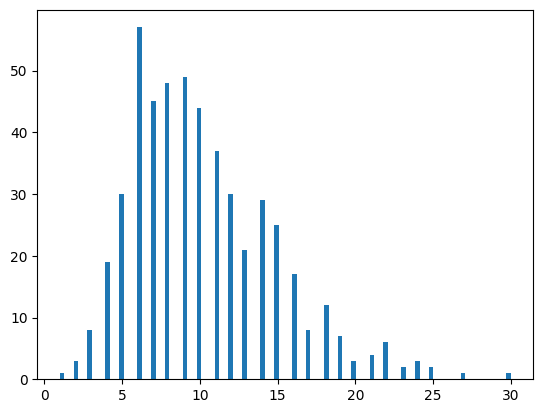

game 49 uses 8 states
game 182 uses 8 states
game 49 uses 11 states
game 182 uses 8 states


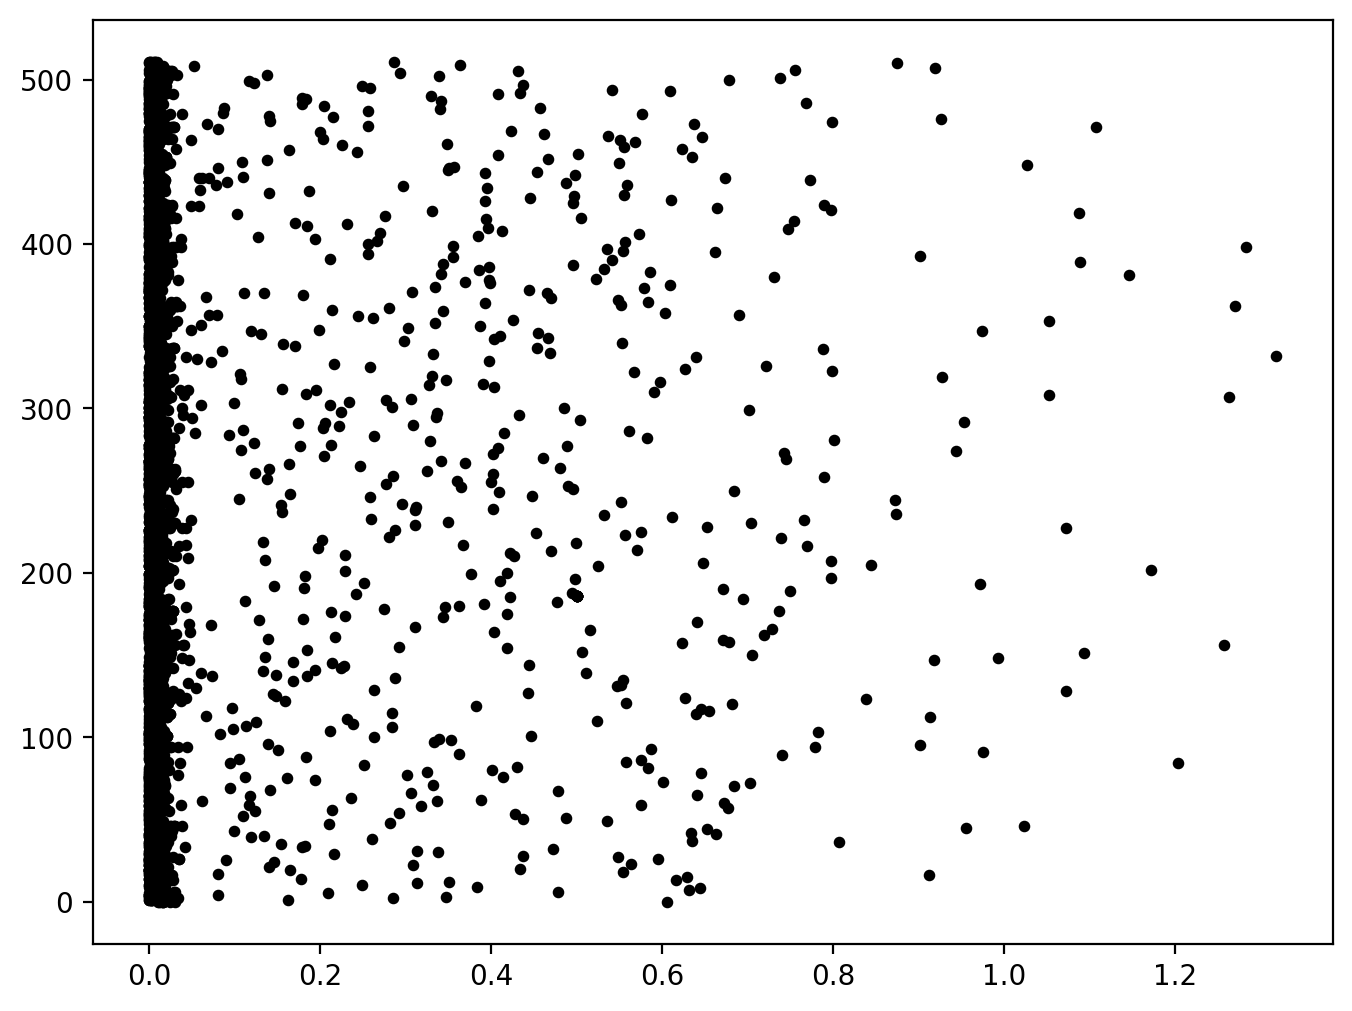

average number of moves in 512 games: 9.234375, longest game = 29 moves


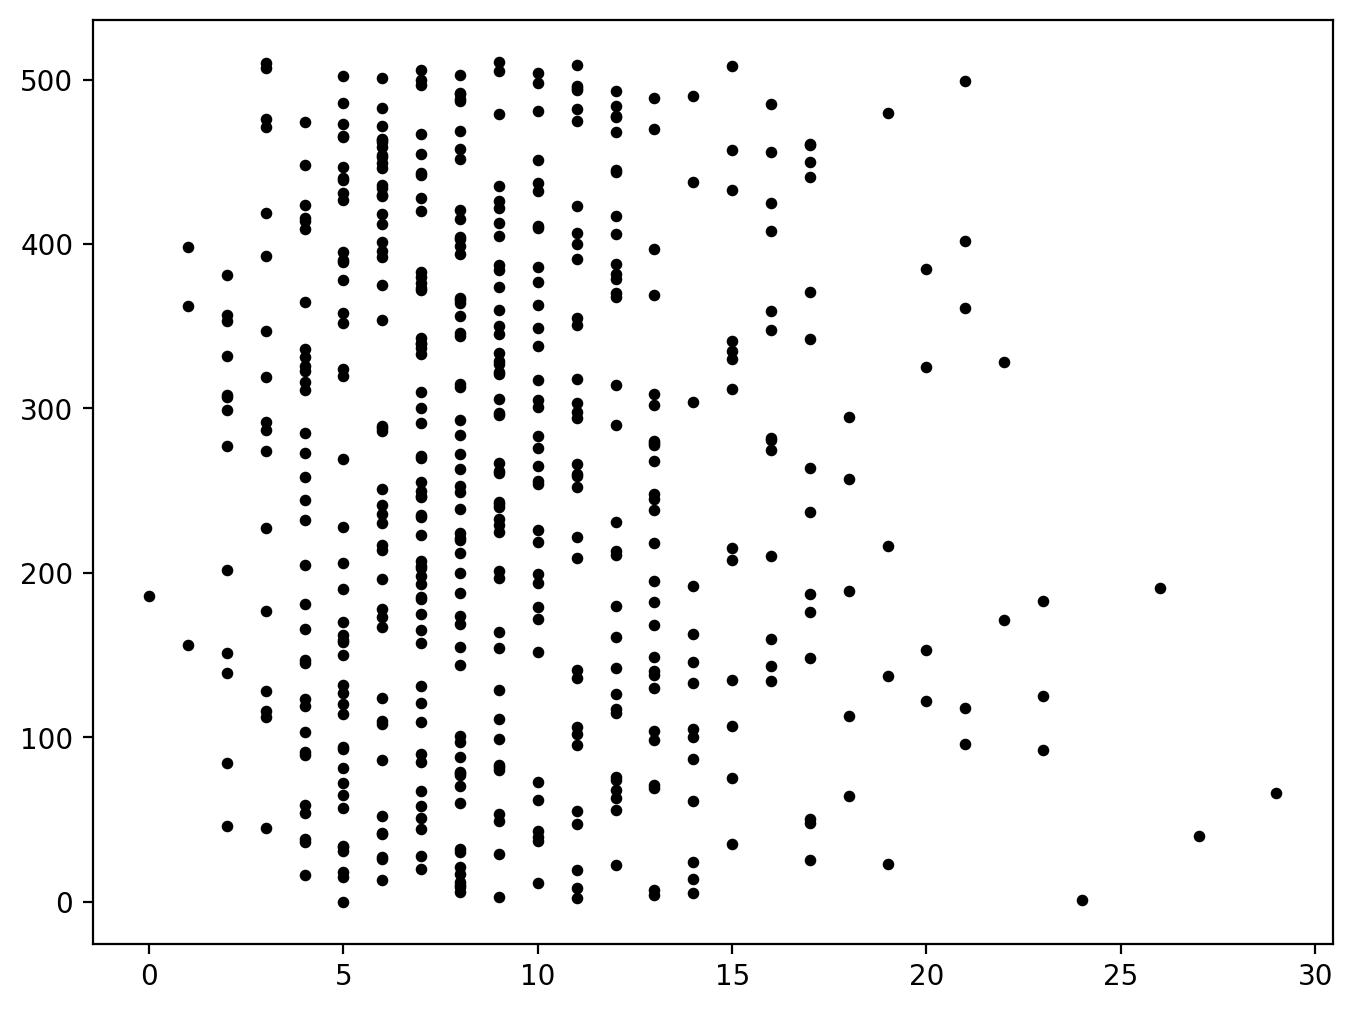

learning_algorithm = Sarsa
num_episodes = 15000
average_moves = 9.068359375
min_Q = 0.0
average_Q = 0.05449673362348162
max_Q = 1.3182035546267952
max_moves = 32


In [1130]:
start_run()